Data Collection

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.read_csv('/content/drive/MyDrive/machine learning/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/machine learning/test.csv')

Data Analysis

In [3]:
## A. Missing Value Analysis
# Calculating percentage of missing data per column
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100

print("--- Missing Values ---")
print(pd.DataFrame({'Total': missing_values, 'Percentage': missing_pct}).filter(items=missing_values[missing_values > 0].index, axis=0))

## B. Duplication Check
duplicates = train_df.duplicated().sum()
print(f"\nTotal Duplicate Rows: {duplicates}")

## C. Class Balance (Target Variable)
# Checking if 'Survived' is imbalanced
survival_balance = train_df['Survived'].value_counts(normalize=True) * 100
print("\n--- Survival Balance ---")
print(f"Died (0): {survival_balance[0]:.2f}%")
print(f"Survived (1): {survival_balance[1]:.2f}%")

## D. Correlation Analysis
# We only correlate numerical columns
numerical_df = train_df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

print("\n--- Correlation with Survived ---")
print(correlation_matrix['Survived'].sort_values(ascending=False))

--- Missing Values ---
          Total  Percentage
Age         177   19.865320
Cabin       687   77.104377
Embarked      2    0.224467

Total Duplicate Rows: 0

--- Survival Balance ---
Died (0): 61.62%
Survived (1): 38.38%

--- Correlation with Survived ---
Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


Visualizing the Insights

/tmp/ipython-input-3027473329.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='Survived', palette='viridis')


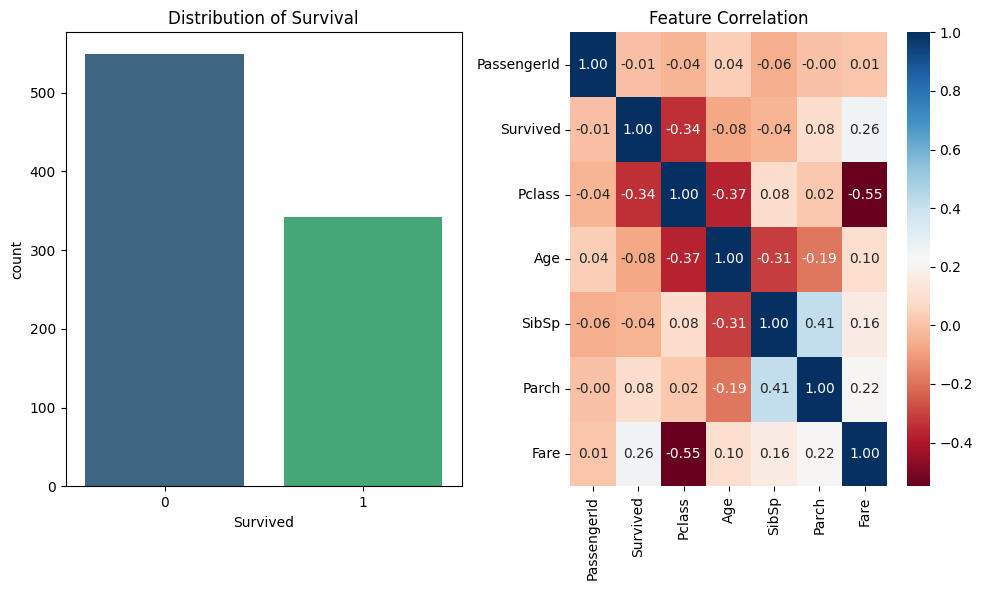

In [4]:
# Visualization Code
plt.figure(figsize=(10, 6))

# Subplot 1: Survival Count
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='Survived', palette='viridis')
plt.title('Distribution of Survival')

# Subplot 2: Correlation Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Feature Correlation')

plt.tight_layout()
plt.show()

Data Preprocessing

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Feature Selection: Drop columns that are unique to individuals
# (High cardinality features like Name/Ticket often lead to overfitting)
df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# 2. Imputing Missing Values
# Fill Age with median to avoid being skewed by outliers
df['Age'] = df['Age'].fillna(df['Age'].median())
# Fill Embarked with the most common port (Mode)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 3. Encoding Categorical Data
# Gender: male/female -> 0/1
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

# Port: C, Q, S -> One-Hot Encoding (creates separate columns)
df = pd.get_dummies(df, columns=['Embarked'], prefix='Port')

# 4. Feature Scaling
# Models like XGBoost are robust, but scaling helps with convergence
scaler = StandardScaler()
numerical_cols = ['Age', 'Fare', 'SibSp', 'Parch']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 5. Train-Test Split
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Preprocessing complete. Training shape: {X_train.shape}")

Preprocessing complete. Training shape: (712, 9)


Creating the Model (The "Overfit" Experiment)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step A: The Overfit Model
# 'max_depth=None' is the culprit here—it lets the tree grow until it's "perfect"
overfit_rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
overfit_rf.fit(X_train, y_train)

train_acc = accuracy_score(y_train, overfit_rf.predict(X_train))
test_acc = accuracy_score(y_test, overfit_rf.predict(X_test))

print(f"--- Overfit Model Results ---")
print(f"Training Accuracy: {train_acc:.2%}") # Expect ~98-100%
print(f"Test Accuracy: {test_acc:.2%}")     # Expect much lower

--- Overfit Model Results ---
Training Accuracy: 97.89%
Test Accuracy: 80.45%


The "Regularized" Model (XGBoost)

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost Classifier with Regularization
# reg_alpha is L1 and reg_lambda is L2
fixed_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,            # Shallow trees generalize better
    learning_rate=0.1,      # Slow down learning to capture patterns, not noise
    reg_alpha=1.0,          # L1 Regularization
    reg_lambda=1.5,         # L2 Regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model
fixed_model.fit(X_train, y_train)

# Predictions
train_pred = fixed_model.predict(X_train)
test_pred = fixed_model.predict(X_test)

print(f"--- Regularized Model Results ---")
print(f"Training Accuracy: {accuracy_score(y_train, train_pred):.2%}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.2%}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:34:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Regularized Model Results ---
Training Accuracy: 88.06%
Test Accuracy: 81.56%


Evaluation

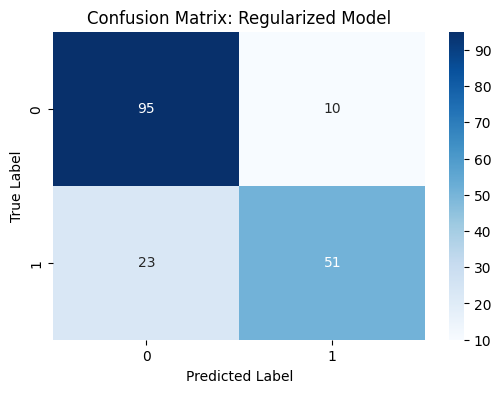

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create the Confusion Matrix array
cm = confusion_matrix(y_test, test_pred)

# 2. Plot using seaborn (sns)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Regularized Model')
plt.show()

In [12]:
import joblib

# Save the trained model to a file
joblib.dump(fixed_model, 'titanic_best_model.pkl')

# Save the scaler as well (crucial for future new data!)
joblib.dump(scaler, 'titanic_scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
